Matching spectra for *a*-opic irradiance with STLAB
===================================================

When designing stimuli with STLAB, you may wish simply to find the settings that most closely match a spectrum that you measured elsewhere. In this example, we are aiming to match the spectral output of a NeurOptics PLR-3000 automated pupillometer, which administers light stimuli with 4 white LEDs. We measured the spectral output of the PLR-3000 with an OceanOptics STS-VIS spectrometer placed where the eye would normally be, and calibrated using our standard pipeline.

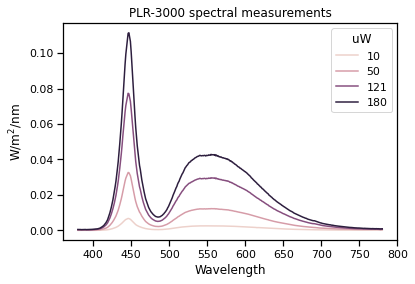

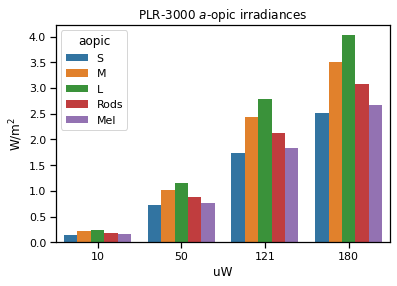

In [151]:
import pandas as pd
import seaborn as sns
sns.set_context('notebook')

# Load data
plr3000 = pd.read_csv('../data/PLR-3000_oo_calibrated_spectra.csv', index_col='uW')
plr3000.columns = plr3000.columns.astype('int')

# Plot spectra
specs = (plr3000.reset_index()
                .melt(id_vars='uW', var_name='Wavelength', value_name='w/m2/nm')
                .sort_values(['uW','Wavelength'])
                .reset_index(drop=True))
ax = sns.lineplot(data=specs, x='Wavelength', y='w/m2/nm', units='uW', hue='uW', estimator=None)
ax.set_ylabel('W/m$^2$/nm')
ax.set_title('PLR-3000 spectral measurements')

# Plot a-opic irradiances
sss = get_CIES026(asdf=True)
sss = sss.fillna(0)
plr_3k_ao = plr3000.dot(sss)
data = (plr_3k_ao.reset_index()
                 .melt(id_vars=['uW'], 
                       var_name=['aopic'], 
                       value_name='irradiance'))
f2, ax2 = plt.subplots()
sns.barplot(
    data=data, x='uW', y='irradiance', hue='aopic', ax=ax2)
ax2.set_ylabel('W/m$^2$')
ax2.set_title('PLR-3000 $a$-opic irradiances');

The first thing we need is to make a `CalibrationContext` from our calibrated OceanOptics data.

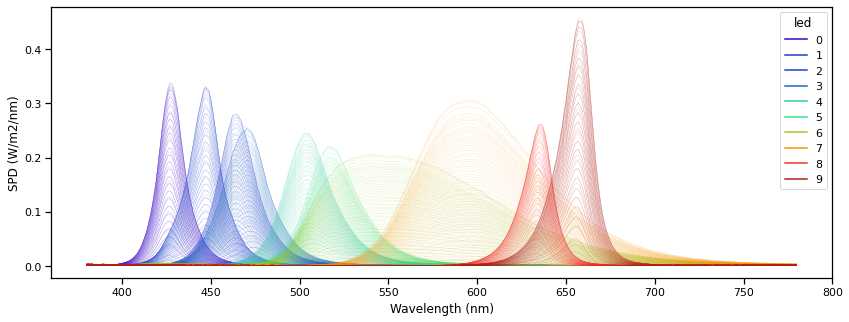

In [149]:
from pyplr.calibrate import CalibrationContext

cc = CalibrationContext(
    '../data/S2_corrected_oo_spectra.csv', binwidth=1)
_ = cc.plot_calibrated_spectra()

Now we will search for STLAB settings that match the PLR-3000 180 uW setting for *a*-opic irradiance. For all possible combinations in 10 choose 5 (one LED for each photoreceptor class), we use linear algebra to work out the input fraction of the chosen LEDs that is required for matching the spectrum. Note that we will only keep settings if the input fractions are between 0 and 1, because eventually we will need to convert these to 12-bit STLAB settings.  

In [141]:
import itertools

import numpy as np

# At least 5 LEDs are required here
uW_setting = 180
num_leds = 5
use = ['L','M','S','Mel', 'Rods']
keep = []

# Loop through all possible combinations in 10 choose 5
for choose in itertools.combinations(range(10), num_leds):
    
    # Get the irradiances for each LED at maximum
    settings_to_irradiances = cc.aopic.loc[[(led, 4095) for led in choose], use]
    
    # Take the inverse
    irradiances_to_settings = np.linalg.inv(settings_to_irradiances)
    
    # Calculate the required input fraction for the chosen LEDs
    plr_irradiances = plr_3k_ao.loc[uW_setting, use].T
    settings = plr_irradiances.dot(irradiances_to_settings)

    # Keep the settings where all values are greater than 0 and less then 1
    if all(settings < 1) and all(settings > 0):
        keep.append((uW_setting, choose, settings))
        
print('\n' + str(len(keep)) + ' settings found')
keep


18 settings found


[(180,
  (0, 1, 2, 6, 7),
  array([0.00531917, 0.3216303 , 0.02017206, 0.19448565, 0.01638168])),
 (180,
  (0, 1, 2, 6, 8),
  array([0.31467891, 0.06027982, 0.10188467, 0.20215462, 0.06109765])),
 (180,
  (0, 1, 2, 6, 9),
  array([0.35743549, 0.02340809, 0.11354845, 0.20235183, 0.07317351])),
 (180,
  (0, 1, 3, 6, 7),
  array([0.01693603, 0.31685753, 0.01834595, 0.19404771, 0.01661427])),
 (180,
  (0, 1, 3, 6, 8),
  array([0.40047265, 0.01481659, 0.09831599, 0.20039123, 0.06574652])),
 (180,
  (0, 2, 3, 6, 9),
  array([0.40061914, 0.06456956, 0.04767865, 0.20150394, 0.07587359])),
 (180,
  (0, 2, 4, 6, 7),
  array([0.4194542 , 0.08726618, 0.0433025 , 0.17252957, 0.02816172])),
 (180,
  (0, 2, 4, 6, 8),
  array([0.38998566, 0.11677266, 0.00512252, 0.20020968, 0.06629503])),
 (180,
  (0, 2, 4, 6, 9),
  array([0.38657506, 0.11941011, 0.00189081, 0.20164011, 0.07547113])),
 (180,
  (0, 2, 5, 6, 7),
  array([0.40014292, 0.1076887 , 0.05468808, 0.15675642, 0.03600865])),
 (180,
  (0, 2, 5, 6

The next step is to convert to 12-bit STLAB settings.

In [152]:
settings = []
predicted = pd.DataFrame()

vals = [val[1:] for val in keep if val[0]]
for k in vals:
    leds = k[0]
    
    # Convert to 12-bit integer
    intensities = np.round(k[1] * 4095).astype('int')
    spec = [0]*10
    for led, i in zip(leds, intensities):
        spec[led] = i
    pred = cc.predict_spd(spec)
    predicted = predicted.append(pred)
    settings.append(spec) 
        
settings = pd.DataFrame(settings)
predicted.reset_index(inplace=True, drop=True)

# In theory it doesn't matter which one we pick, but here 
best = predicted.sub(plr3000.loc[uW_setting].to_numpy()).pow(2).sum(axis=1).idxmin()

optimal_predicted = predicted.loc[best]
optimal_settings = settings.loc[best]

Visualise our results

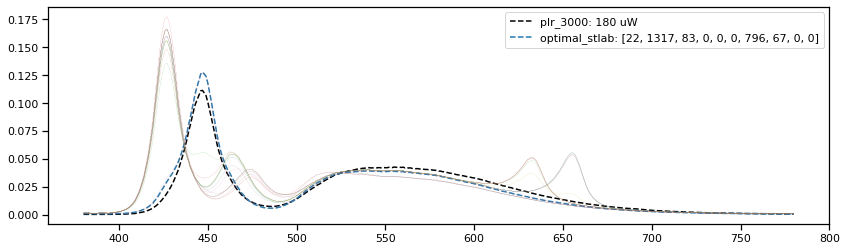

In [153]:
fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(14,4))
plr3000.loc[uW_setting].plot(
    label='plr_3000: {} uW'.format(
        uW_setting), ax=ax, color='k', linestyle='--')
ax.plot(plr3000.columns, 
        optimal_predicted, 
        label='optimal_stlab: ' + str(optimal_settings.to_list()), 
        linestyle='--')
ax.legend()
for idx, p in predicted.iterrows():
    p.plot(lw=.1)

Make video file

In [147]:
from pyplr.stlab import pulse_protocol, video_file_to_dict
pulse_protocol(pulse_spec=spec,
               pulse_duration=1000,
               fname='PLR-3000-{}-mw'.format(uW_setting))

"PLR-3000-180-mw.dsf" saved in the current working directory.


In [148]:
vf = video_file_to_dict('PLR-3000-180-mw.dsf')
vf

{'header': {'version': 1,
  'model': 'VEGA10',
  'channels': 10,
  'spectracount': 4,
  'transitionsCount': 4,
  'fluxReference': 0,
  'repeats': 1},
 'metadata': {'creation_time': '2021-04-08 15:20:32.923123',
  'creator': 'jtm',
  'protocol': 'pulse',
  'pulse_spec': '[1716, 0, 0, 419, 0, 0, 821, 0, 182, 106]',
  'pulse_duration': '1000'},
 'spectra': [[1716, 0, 0, 419, 0, 0, 821, 0, 182, 106],
  [1716, 0, 0, 419, 0, 0, 821, 0, 182, 106],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 'transitions': [{'spectrum': 0, 'power': 100, 'time': 0, 'flags': 0},
  {'spectrum': 1, 'power': 100, 'time': 1000, 'flags': 0},
  {'spectrum': 2, 'power': 100, 'time': 1000, 'flags': 0},
  {'spectrum': 3, 'power': 100, 'time': 1100, 'flags': 0}]}